## Hackweek ideas:

- Ignore lighting of image: convert to grayscale (perhaps with normalization)
- Use contrastive leanring to get better embedding representations
- Use segmentation to isolate just the house, suppress the background

## Use Embedding Layer of Pretrained Model

Idea: use the embedding layer, then precompute embedding values on our dataset, then for a new image run it through our embedding model to then compare with all the precomputed values. Find images where cosine similarity of the vectors is high (i.e. distance is small).

UX could, for example, be one of the follwing: using prior web activity, what the user liked, or a user uploaded image

# Package Required 
pip install tensorflow
pip install streamlit
pip install faiss-cpu

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_16_preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import glob
import json
from PIL import Image
from matplotlib.pyplot import imshow
import faiss

from tensorflow.keras.metrics import CosineSimilarity
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
input_shape = (256, 256, 3)
height = input_shape[0]
width = input_shape[1]

In [3]:
model_name = 'VGG16'
assert model_name in ['VGG16', 'DenseNet121', 'EfficientNetV2M', 'Xception', 'ResNet50V2']

In [4]:
if model_name == 'VGG16':
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocess_function = vgg_16_preprocess_input
elif model_name == 'DenseNet121':
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocess_function = densenet_preprocess_input
elif model_name == 'EfficientNetV2M':
    base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocess_function = efficientnet_v2_preprocess_input
elif model_name == 'Xception':
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocess_function = xception_preprocess_input
elif model_name == 'ResNet50V2':
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocess_function = resnet_v2_preprocess_input

In [5]:
def get_embedding_model():
    last = base_model.layers[-1].output
    x = layers.GlobalMaxPooling2D()(last)
    embedding = Model(base_model.input, x)
    
    return embedding
    
model = get_embedding_model()

In [6]:
def convert_image_to_array(path):
    return np.asarray(Image.open(path), dtype=np.float32)

In [7]:
def model_preprocess(path, height, width):
    x = convert_image_to_array(path=path)
    x_shape = x.shape

    if (len(x_shape) == 2) or ((len(x_shape) == 3) and (x_shape[-1] == 1)):
        x = np.array([x, x, x])
        x = np.moveaxis(x, 0, -1)
        
    x = tf.image.resize_with_pad(image=x, target_height=height, target_width=width)
    x /= 255.
    x = np.expand_dims(x, axis=0)
    return x

In [8]:
def get_embedding_vector(img_path: str,  model, height: int, width: int, preprocess_function) -> np.array:
    img = image.load_img(img_path, target_size=(height, width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_function(x)

    embedding = model.predict(x)
    return embedding

In [9]:
m = CosineSimilarity(axis=1)

In [10]:
img1_path = 'PropertyImages/image52.jpg'
embedding1 = get_embedding_vector(img_path=img1_path, model=model, height=height, width=width, preprocess_function=preprocess_function)

1/1 [==============================] - 0s 280ms/step


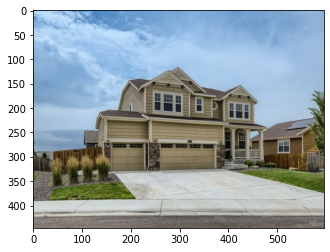

In [11]:
pil_im = Image.open(img1_path, 'r')
imshow(np.asarray(pil_im))

In [12]:
model

In [13]:
img2_path = 'PropertyImages/image50.jpg'
embedding2 = get_embedding_vector(img_path=img2_path, model=model, height=height, width=width, preprocess_function=preprocess_function)

1/1 [==============================] - 0s 140ms/step


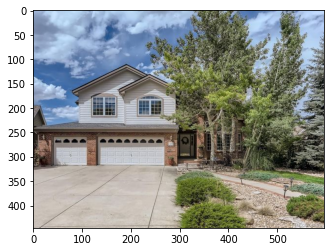

In [14]:
pil_im = Image.open(img2_path, 'r')
imshow(np.asarray(pil_im))

In [15]:
m.update_state(embedding1, embedding2)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [16]:
m.result().numpy()

0.73298025

### Loop through all images and calculate the embeddings

Pre compute all of the embedding vectors and store it in a dataframe

In [17]:
img_paths1 = glob.glob("PropertyImages/*.jp*")
#img_paths2 = glob.glob("./data/raw_data/Houses_Dataset/*frontal.jp*")
img_paths = img_paths1 #+ img_paths2

In [18]:
img_paths.sort()

In [19]:
embedding_vectors_dict = {}

for i, img_path in enumerate(img_paths):
    if (i % 10) == 0:
        print(f'{i} out of {len(img_paths)}')
    embedding = get_embedding_vector(img_path=img_path, model=model, height=height, width=width, preprocess_function=preprocess_function)
    embedding_vectors_dict[img_path] = {'embedding_vector': embedding}

0 out of 100
1/1 [==============================] - 0s 144ms/step
10 out of 100
1/1 [==============================] - 0s 149ms/step
20 out of 100
1/1 [==============================] - 0s 145ms/step
30 out of 100
1/1 [==============================] - 0s 154ms/step
40 out of 100
1/1 [==============================] - 0s 145ms/step
50 out of 100
1/1 [==============================] - 0s 155ms/step
60 out of 100
1/1 [==============================] - 0s 158ms/step
70 out of 100
1/1 [==============================] - 0s 146ms/step
80 out of 100
1/1 [==============================] - 0s 179ms/step
90 out of 100
1/1 [==============================] - 0s 179ms/step


In [20]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [21]:
df_embedding_vectors = pd.DataFrame.from_dict(embedding_vectors_dict, columns=['embedding_vector'], orient='index')
image_embedding = np.asarray( df_embedding_vectors['embedding_vector'].to_list())
sample_arr = np.asarray(list(np.array(image_embedding[i][0]).astype(np.float32) for i in range(len(image_embedding))))

In [22]:
# Shape Of the Embedding Vectors
d = sample_arr[0].shape[0]


# Intialiaze Faiss Index and Add Our Embedding vector Data
index = faiss.IndexFlatL2(d)
faiss.normalize_L2(sample_arr)
index.add(sample_arr)

In [23]:
# save Faiss Index
filename = f'Faiss_Index_{model_name}'
faiss.write_index(index , filename)

In [24]:
# Save The Image Paths

# open file in write mode
with open(f'Image_Paths_For_Model.txt', 'w') as fp:
    for item in list(df_embedding_vectors.index):
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


### Load The Faiss Index For Similarity Search

In [25]:
# Load The Index
index2 = faiss.read_index(filename)

# Load File Path

file_paths = []
with open(f'Image_Paths_For_Model.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        file_paths.append(x)


In [26]:
file_paths

['PropertyImages\\image1.jpeg',
 'PropertyImages\\image1.jpg',
 'PropertyImages\\image10.jpeg',
 'PropertyImages\\image10.jpg',
 'PropertyImages\\image100.jpg',
 'PropertyImages\\image11.jpeg',
 'PropertyImages\\image11.jpg',
 'PropertyImages\\image12.jpg',
 'PropertyImages\\image13.jpg',
 'PropertyImages\\image14.jpg',
 'PropertyImages\\image15.jpg',
 'PropertyImages\\image16.jpg',
 'PropertyImages\\image17.jpg',
 'PropertyImages\\image18.jpg',
 'PropertyImages\\image19.jpg',
 'PropertyImages\\image2.jpeg',
 'PropertyImages\\image2.jpg',
 'PropertyImages\\image20.jpg',
 'PropertyImages\\image21.jpg',
 'PropertyImages\\image22.jpg',
 'PropertyImages\\image23.jpg',
 'PropertyImages\\image24.jpg',
 'PropertyImages\\image25.jpg',
 'PropertyImages\\image26.jpg',
 'PropertyImages\\image27.jpg',
 'PropertyImages\\image28.jpg',
 'PropertyImages\\image29.jpg',
 'PropertyImages\\image3.jpg',
 'PropertyImages\\image30.jpg',
 'PropertyImages\\image31.jpg',
 'PropertyImages\\image32.jpg',
 'Proper

In [27]:
# Get The Embedding Which We Want To Find The Similar Images
BASE_EMBEDDING = get_embedding_vector(img_path=img1_path, model=model, height=height, width=width , preprocess_function=preprocess_function)


# Search The Similar Model Using Faiss Index Model
D, I = index2.search(BASE_EMBEDDING[0:1] , 5)

1/1 [==============================] - 0s 138ms/step


## Search For Similar Images

### Source Image

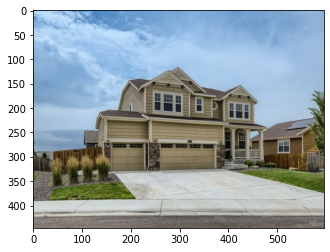

In [28]:
pil_im = Image.open(img1_path, 'r')
imshow(np.asarray(pil_im))

### Similar Images

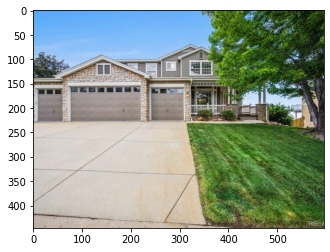

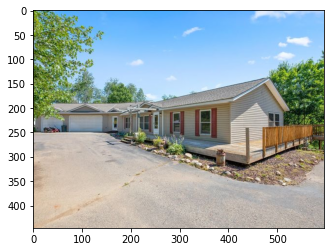

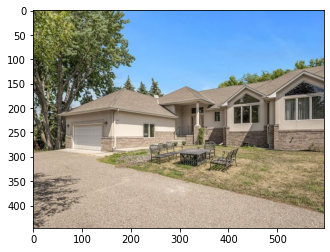

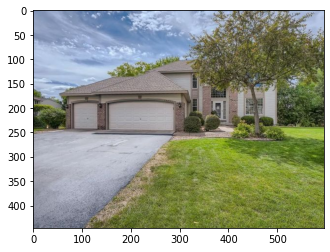

In [29]:

c =0 

# To Show The Images
for i in I[0][1:]:
    
    plt.figure(c)
    im = Image.open(df_embedding_vectors.iloc[i].name)
    plt.imshow(im)
    c+=1

# Use Contrastive/Metric Learning

The code below follows this example: https://keras.io/examples/vision/nnclr/

In this example, we implement NNCLR as proposed in the paper With a Little Help from My Friends: Nearest-Neighbor Contrastive Learning of Visual Representations, by Google Research and DeepMind.

NNCLR learns self-supervised representations that go beyond single-instance positives, which allows for learning better features that are invariant to different viewpoints, deformations, and even intra-class variations. Clustering based methods offer a great approach to go beyond single instance positives, but assuming the entire cluster to be positives could hurt performance due to early over-generalization. Instead, NNCLR uses nearest neighbors in the learned representation space as positives. In addition, NNCLR increases the performance of existing contrastive learning methods like SimCLR(Keras Example) and reduces the reliance of self-supervised methods on data augmentation strategies.

In [67]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

## Hyperparameters

A greater queue_size most likely means better performance as shown in the original paper, but introduces significant computational overhead. The authors show that the best results of NNCLR are achieved with a queue size of 98,304 (the largest queue_size they experimented on).

In [70]:
unlabelled_images = len(img_paths)
unlabelled_images

100

In [71]:
BASE_ENCODER_MODEL = 'Xception'
assert BASE_ENCODER_MODEL in ['Xception', 'ResNet50V2']

if BASE_ENCODER_MODEL == 'Xception':
    PREPROCESS_FUNCTION = xception_preprocess_input
elif BASE_ENCODER_MODEL == 'ResNet50V2':
    PREPROCESS_FUNCTION = resnet_v2_preprocess_input

In [72]:
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5000
labelled_train_images = 0
unlabelled_images = unlabelled_images

temperature = 0.1
queue_size = 10000
contrastive_augmenter = {
    "brightness": 0.5,
    "name": "contrastive_augmenter",
    "scale": (0.2, 1.0),
}
classification_augmenter = {
    "brightness": 0.2,
    "name": "classification_augmenter",
    "scale": (0.5, 1.0),
}
# input_shape = (96, 96, 3)
# width = 128
input_shape = (256, 256, 3)
width = 512
num_epochs = 25
steps_per_epoch = unlabelled_images // 16

In [73]:
def parse_function(img_path: tf.Tensor) -> np.array:
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    x = image.img_to_array(img)
    x = PREPROCESS_FUNCTION(x)
    
    return x

In [74]:
def prepare_dataset():
    unlabeled_batch_size = unlabelled_images // steps_per_epoch
    labeled_batch_size = labelled_train_images // steps_per_epoch
    batch_size = unlabeled_batch_size + labeled_batch_size
    
    parsed_images = [parse_function(img_path) for img_path in img_paths]
    dataset = tf.data.Dataset.from_tensor_slices(parsed_images)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(unlabeled_batch_size, drop_remainder=True)
    
    return batch_size, dataset

In [75]:
batch_size, dataset = prepare_dataset()

In [76]:
# dataset_name = 'homes'

# def prepare_dataset():
#     unlabeled_batch_size = unlabelled_images // steps_per_epoch
#     labeled_batch_size = labelled_train_images // steps_per_epoch
#     batch_size = unlabeled_batch_size + labeled_batch_size

#     unlabeled_train_dataset = (
#         tfds.load(
#             dataset_name, split="unlabelled", as_supervised=True, shuffle_files=True
#         )
#         .shuffle(buffer_size=shuffle_buffer)
#         .batch(unlabeled_batch_size, drop_remainder=True)
#     )
#     labeled_train_dataset = (
#         tfds.load(dataset_name, split="train", as_supervised=True, shuffle_files=True)
#         .shuffle(buffer_size=shuffle_buffer)
#         .batch(labeled_batch_size, drop_remainder=True)
#     )
#     test_dataset = (
#         tfds.load(dataset_name, split="test", as_supervised=True)
#         .batch(batch_size)
#         .prefetch(buffer_size=AUTOTUNE)
#     )
#     train_dataset = tf.data.Dataset.zip(
#         (unlabeled_train_dataset, labeled_train_dataset)
#     ).prefetch(buffer_size=AUTOTUNE)

#     return batch_size, train_dataset, labeled_train_dataset, test_dataset


# batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

## Augmentations

Other self-supervised techniques like SimCLR, BYOL, SwAV etc. rely heavily on a well-designed data augmentation pipeline to get the best performance. However, NNCLR is less dependent on complex augmentations as nearest-neighbors already provide richness in sample variations. A few common techniques often included augmentation pipelines are:

- Random resized crops
- Multiple color distortions
- Gaussian blur

Since NNCLR is less dependent on complex augmentations, we will only use random crops and random brightness for augmenting the input images.

### Random Resized Crops

In [77]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super(RandomResizedCrop, self).__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images

### Random Brightness

In [78]:
class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super(RandomBrightness, self).__init__()
        self.brightness = brightness

    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def call(self, images):
        images = self.random_brightness(images)
        return images

### Prepare augmentation module

In [79]:
def augmenter(brightness, name, scale):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
            RandomBrightness(brightness=brightness),
        ],
        name=name,
    )

### Encoder architecture

Using a ResNet-50 as the encoder architecture is standard in the literature. In the original paper, the authors use ResNet-50 as the encoder architecture and spatially average the outputs of ResNet-50. However, keep in mind that more powerful models will not only increase training time but will also require more memory and will limit the maximal batch size you can use. For the purpose of this example, we just use four convolutional layers.

In [80]:
def base_encoder():
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

In [142]:
#encoder.summary()

## Another Encoder

We will use a pre-trained model in order to fine tune our encoder. This will help us both start with better embedding features, and also use a more expressive model than the base encoder model used for demo purposes in the blog post

In [81]:
def freeze_layers(model, freeze_layer_name):
    for layer in model.layers:
        if layer.name != freeze_layer_name:
            layer.trainable = False
        else:
            layer.trainable = False
            break
            
def unfreeze_batch_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'BatchNormalization':
            layer.trainable = True
            
def print_layer_trainable(model):
    for layer in model.layers:
        print('{0}:\t{1}'.format(layer.trainable, layer.name))

In [82]:
def encoder():
    if BASE_ENCODER_MODEL == 'Xception':
        encoder_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
        last = encoder_base.layers[-1].output
        x = layers.Flatten(name='flatten')(last)
        x = layers.Dense(width, name='embedding')(x)
        encoder = Model(encoder_base.input, x, name='Xception')
        freeze_layers(encoder, 'add_11')
        unfreeze_batch_norm(encoder)
    elif BASE_ENCODER_MODEL == 'ResNet50V2':
        encoder_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
        last = encoder_base.layers[-1].output
        x = layers.Flatten(name='flatten')(last)
        x = layers.Dense(width, name='embedding')(x)
        encoder = Model(encoder_base.input, x, name='ResNet50V2')
        freeze_layers(encoder, 'flatten')
        unfreeze_batch_norm(encoder)
        
    return encoder

In [145]:
# encoder = encoder()

In [146]:
#encoder.summary()

### The NNCLR model for contrastive pre-training

We train an encoder on unlabeled images with a contrastive loss. A nonlinear projection head is attached to the top of the encoder, as it improves the quality of representations of the encoder.

Note we don't have any labeled data for our problem, so we will make updates to the code below to reflect that.

In [83]:
from tensorflow import keras
class NNCLR(keras.Model):
    def __init__(self, temperature, queue_size,):
        super(NNCLR, self).__init__()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_augmenter = augmenter(**contrastive_augmenter)
        self.classification_augmenter = augmenter(**classification_augmenter)
        self.encoder = encoder()
        self.projection_head = keras.Sequential(
            [
                layers.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)], name="linear_probe"
        )
        self.temperature = temperature

        feature_dimensions = self.encoder.output_shape[1]
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1
            ),
            trainable=False,
        )

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super(NNCLR, self).compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(
            projections, self.feature_queue, transpose_b=True
        )
        nn_projections = tf.gather(
            self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0
        )
        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    def update_correlation_accuracy(self, features_1, features_2):
        features_1 = (
            features_1 - tf.reduce_mean(features_1, axis=0)
        ) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (
            features_2 - tf.reduce_mean(features_2, axis=0)
        ) / tf.math.reduce_std(features_2, axis=0)

        batch_size = tf.shape(features_1, out_type=tf.float32)[0]
        cross_correlation = (
            tf.matmul(features_1, features_2, transpose_a=True) / batch_size
        )

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
        )

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        similarities_1_2_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_1), projections_2, transpose_b=True
            )
            / self.temperature
        )
        similarities_1_2_2 = (
            tf.matmul(
                projections_2, self.nearest_neighbour(projections_1), transpose_b=True
            )
            / self.temperature
        )

        similarities_2_1_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_2), projections_1, transpose_b=True
            )
            / self.temperature
        )
        similarities_2_1_2 = (
            tf.matmul(
                projections_1, self.nearest_neighbour(projections_2), transpose_b=True
            )
            / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                ],
                axis=0,
            ),
            tf.concat(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0,
            ),
            from_logits=True,
        )

        self.feature_queue.assign(
            tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0)
        )
        return loss

    def train_step(self, data):
        unlabeled_images = data
        images = unlabeled_images
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)

        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)
#         preprocessed_images = self.classification_augmenter(labeled_images)

#         with tf.GradientTape() as tape:
#             features = self.encoder(preprocessed_images)
#             class_logits = self.linear_probe(features)
#             probe_loss = self.probe_loss(labels, class_logits)
#         gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
#         self.probe_optimizer.apply_gradients(
#             zip(gradients, self.linear_probe.trainable_weights)
#         )
#         self.probe_accuracy.update_state(labels, class_logits)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result(),
            "p_loss": 0, #probe_loss,
            "p_acc": 0, #self.probe_accuracy.result(),
        }

    def test_step(self, data):
#         labeled_images, labels = data

#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
#         features = self.encoder(preprocessed_images, training=False)
#         class_logits = self.linear_probe(features, training=False)
#         probe_loss = self.probe_loss(labels, class_logits)

#         self.probe_accuracy.update_state(labels, class_logits)
#         return {"p_loss": probe_loss, "p_acc": self.probe_accuracy.result()}
        return {"p_loss": 0, "p_acc": 0}

### Pre-train NNCLR

We train the network using a temperature of 0.1 as suggested in the paper and a queue_size of 10,000 as explained earlier. We use Adam as our contrastive and probe optimizer. For this example we train the model for only 30 epochs but it should be trained for more epochs for better performance.

The following two metrics can be used for monitoring the pretraining performance which we also log (taken from this Keras example):

- Contrastive accuracy: self-supervised metric, the ratio of cases in which the representation of an image is more similar to its differently augmented version's one, than to the representation of any other image in the current batch. Self-supervised metrics can be used for hyperparameter tuning even in the case when there are no labeled examples.
- Linear probing accuracy: linear probing is a popular metric to evaluate self-supervised classifiers. It is computed as the accuracy of a logistic regression classifier trained on top of the encoder's features. In our case, this is done by training a single dense layer on top of the frozen encoder. Note that contrary to traditional approach where the classifier is trained after the pretraining phase, in this example we train it during pretraining. This might slightly decrease its accuracy, but that way we can monitor its value during training, which helps with experimentation and debugging.

In [84]:
model = NNCLR(temperature=temperature, queue_size=queue_size)
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

In [85]:
pretrain_history = model.fit(
    dataset, epochs=num_epochs, validation_data=dataset
)

Epoch 1/25
6/6 [==============================] - 47s 6s/step - c_loss: 2.7723 - c_acc: 0.2875 - r_acc: 0.0356 - p_loss: 0.0000e+00 - p_acc: 0.0000e+00 - val_p_loss: 0.0000e+00 - val_p_acc: 0.0000e+00
Epoch 2/25
6/6 [==============================] - 35s 6s/step - c_loss: 2.7552 - c_acc: 0.4486 - r_acc: 0.0393 - p_loss: 0.0000e+00 - p_acc: 0.0000e+00 - val_p_loss: 0.0000e+00 - val_p_acc: 0.0000e+00
Epoch 3/25
6/6 [==============================] - 36s 6s/step - c_loss: 2.8447 - c_acc: 0.4015 - r_acc: 0.0605 - p_loss: 0.0000e+00 - p_acc: 0.0000e+00 - val_p_loss: 0.0000e+00 - val_p_acc: 0.0000e+00
Epoch 4/25
6/6 [==============================] - 36s 6s/step - c_loss: 2.7661 - c_acc: 0.3685 - r_acc: 0.0426 - p_loss: 0.0000e+00 - p_acc: 0.0000e+00 - val_p_loss: 0.0000e+00 - val_p_acc: 0.0000e+00
Epoch 5/25
6/6 [==============================] - 35s 6s/step - c_loss: 2.7740 - c_acc: 0.3635 - r_acc: 0.0397 - p_loss: 0.0000e+00 - p_acc: 0.0000e+00 - val_p_loss: 0.0000e+00 - val_p_acc: 0.0000

In [86]:
BASE_ENCODER_MODEL

'Xception'

In [87]:
similarity_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        model.encoder
    ],
    name="similarity_model",
)

### Save similarity model

In [88]:
similarity_model.save(filepath=f'similarity_model_{BASE_ENCODER_MODEL}.h5')

### Load saved similarity model

In [89]:
similarity_model = tf.keras.models.load_model(filepath=f'similarity_model_{BASE_ENCODER_MODEL}.h5')

### Calculate embeddings with contrastive trained model 

In [112]:
embedding_vectors_dict = {}

for i, img_path in enumerate(img_paths):
    if (i % 10) == 0:
        print(f'{i} out of {len(img_paths)}')
    embedding = get_embedding_vector(img_path=img_path, model=similarity_model, height=input_shape[0], width=input_shape[1], preprocess_function=PREPROCESS_FUNCTION)
    embedding_vectors_dict[img_path] = {'embedding_vector': embedding}

0 out of 100
1/1 [==============================] - 0s 104ms/step
10 out of 100
1/1 [==============================] - 0s 117ms/step
20 out of 100
1/1 [==============================] - 0s 107ms/step
30 out of 100
1/1 [==============================] - 0s 107ms/step
40 out of 100
1/1 [==============================] - 0s 105ms/step
50 out of 100
1/1 [==============================] - 0s 108ms/step
60 out of 100
1/1 [==============================] - 0s 107ms/step
70 out of 100
1/1 [==============================] - 0s 110ms/step
80 out of 100
1/1 [==============================] - 0s 135ms/step
90 out of 100
1/1 [==============================] - 0s 117ms/step


In [113]:
df_embedding_vectors = pd.DataFrame.from_dict(embedding_vectors_dict, columns=['embedding_vector'], orient='index')
image_embedding = np.asarray( df_embedding_vectors['embedding_vector'].to_list())
sample_arr = np.asarray(list(np.array(image_embedding[i][0]).astype(np.float32) for i in range(len(image_embedding))))

In [114]:
# Shape Of the Embedding Vectors
d = sample_arr[0].shape[0]


# Intialiaze Faiss Index and Add Our Embedding vector Data
index = faiss.IndexFlatL2(d)
faiss.normalize_L2(sample_arr)
index.add(sample_arr)

In [115]:
# save Faiss Index
filename = f'Faiss_Index_embedding_vectors_contrastive_model_{model_name}'
faiss.write_index(index , filename)

In [116]:
# Load The Index
index2 = faiss.read_index(filename)

# Load File Path

file_paths = []
with open(f'Image_Paths_For_Model.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        file_paths.append(x)


In [117]:
# Get The Embedding Which We Want To Find The Similar Images
BASE_EMBEDDING = get_embedding_vector(img_path=img1_path, model=similarity_model, height=height, width=width , preprocess_function=preprocess_function)


# Search The Similar Model Using Faiss Index Model
D, I = index2.search(BASE_EMBEDDING[0:1] , 5)

1/1 [==============================] - 1s 602ms/step


### Source Image

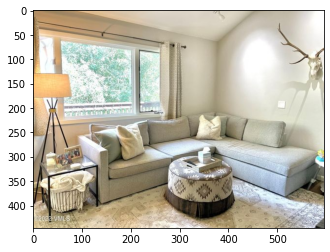

In [118]:
pil_im = Image.open(img1_path, 'r')
imshow(np.asarray(pil_im))

### Similar Images

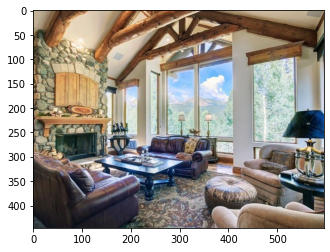

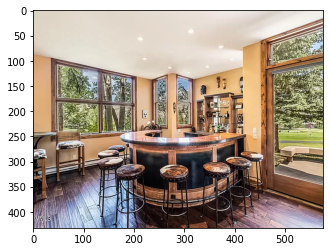

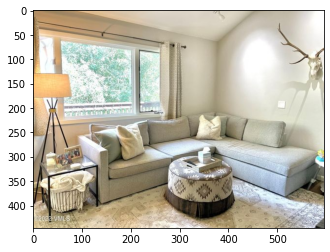

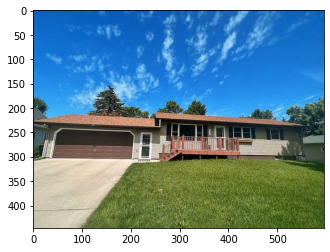

In [119]:

c =0 

# To Show The Images
for i in I[0][1:]:
    
    plt.figure(c)
    im = Image.open(df_embedding_vectors.iloc[i].name)
    plt.imshow(im)
    c+=1